In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score,classification_report,cohen_kappa_score
from sklearn.metrics import roc_curve,auc,precision_score,recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from tqdm import tqdm_notebook
from IPython import display
import scipy
import warnings
warnings.filterwarnings("ignore")
%pylab inline
import os
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
"""
Function for training on training set and testing on testing set
ROC-AUC and ROC curve are shown as results
"""

def results(model, param_grid, cv, X_train,y_train, X_test, y_test):
    optimizer = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1,scoring='f1')
    optimizer.fit(X_train, y_train)

    y_proba = optimizer.best_estimator_.predict_proba(X_train) ###
    y_test1=y_train
    fpr, tpr, threshold = roc_curve(y_test1, y_proba[:,1])
    roc_auc1 = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic for train')
    plt.plot(fpr, tpr, 'b', label = 'AUC1 = %0.2f' % roc_auc1)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    y_proba = optimizer.best_estimator_.predict_proba(X_test) ###
    fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1])
    roc_auc1 = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic for test')
    plt.plot(fpr, tpr, 'b', label = 'AUC1 = %0.2f' % roc_auc1)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print("Model characteristics - ",optimizer.best_estimator_) 
    return optimizer,fpr,tpr,threshold
  
"""
Creation of list of slices (shape 8 by 8) with probabilities of each electrode to be a driver
One slice indicates the 5 seconds duration's window of Fourier spectrum 
"""
def figures_for_slice(data,model,X_scaled_testset, show_figures = False):
    k=int(data.shape[0]/64)
    probabilities = []
    for i in range(k):
        predictions = model.predict_proba(X_scaled_testset)[i*64:(i+1)*64,1]
        probabilities.append(predictions)
        if show_figures:
            resized_y_pred = np.resize(predictions,(8,8))
            plt.figure()
            sns.heatmap(resized_y_pred,vmax = 1,cmap = 'jet', xticklabels='', yticklabels='', cbar=False)
    probabilities = np.array(probabilities)
    return probabilities


"""
Visualization of real and predicted probabilities of electrode grid
The final probability calculates as mean of all slices' probabilities
"""
def figures_with_probabilities(data, y_testset, probabilities):
    print('Real labels')
    resized_y = np.resize(y_testset,(8,8))
    sns.heatmap(resized_y,cmap = 'gray', xticklabels='', yticklabels='', cbar=False)
    
    k=int(data.shape[0]/64)
    print('Predicted labels - only mean of electrodes')
    probabilities_mean = []
    for i in range(64):
        mean_grid=np.mean(probabilities[:,i])
        probabilities_mean.append(mean_grid)
    resized_probabilities_mean = np.resize(probabilities_mean,(8,8))
    plt.figure()
    sns.heatmap(resized_probabilities_mean,cmap = 'jet', xticklabels='', yticklabels='', cbar=True)
    
    return resized_probabilities_mean

In [3]:
path = ''
name = 'F22.csv'
data_with_noise_train=pd.DataFrame()
data_with_noise_test=pd.DataFrame()
for filename in tqdm(glob.glob(os.path.join(path, '*.csv'))):
    if not any(name in filename): 
        #print('not '+filename)
        new_data = pd.read_csv(filename, index_col=0)
        data_with_noise_train = pd.concat([s.reset_index(drop=True) for s in [data_with_noise_train,new_data]], axis=0)
    if any(name in filename): 
        print('selected! '+filename)
        new_data = pd.read_csv(filename, index_col=0)
        data_with_noise_test = pd.concat([s.reset_index(drop=True) for s in [data_with_noise_test,new_data]], axis=0)
data_train = data_with_noise_train.loc[~data_with_noise_train['target'].isin([-1])]
data_train['target'] = data_train['target'].map({1: 1, 0: 0,0.5:1})
data_test= data_with_noise_test
data_test['target'] = data_with_noise_test['target'].map({1: 1, 0: 0,0.5:1,-1:0})

 41%|█████████████████████████████████▎                                                | 13/32 [00:00<00:01, 14.05it/s]

selected! D:\Data\reannotation\Features\semidrivers\separated features semidrivers\Feature matrix electrode signal AF semidrivers with flags F22.csv


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 13.59it/s]


In [4]:
X_neighbour_train = data_train.drop(data_train.columns[:35], 1)
X_neighbour_train = X_neighbour_train.drop('target', 1)
X_neighbour_train = X_neighbour_train.drop('flag', 1)
y_train = data_train['target']
print("Train shape is",X_neighbour_train.shape)
normalizer = pd.read_csv('' +'\AF MEM neigbour normalizer.csv', index_col=0)
X_scaled_train = (X_neighbour_train-normalizer.iloc[:,0])/normalizer.iloc[:,1]

X_neighbour_test = data_test.drop(data_test.columns[:35], 1)
X_neighbour_test = X_neighbour_test.drop('target', 1)
X_neighbour_test = X_neighbour_test.drop('flag', 1)
print("Test shape is",X_neighbour_test.shape)
y_testset = data_test['target']
X_scaled_testset = (X_neighbour_test-normalizer.iloc[:,0])/normalizer.iloc[:,1]

Train shape is (25344, 35)
Test shape is (1600, 35)


### kNN

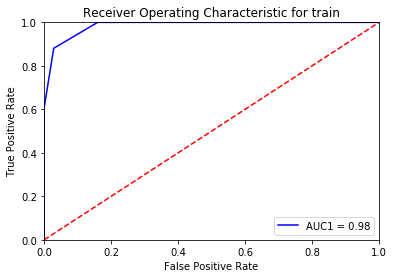

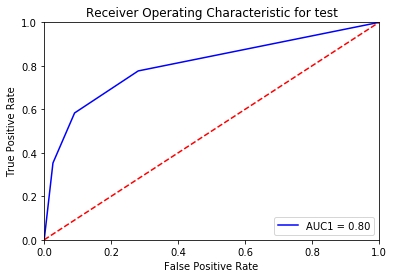

Model characteristics -  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


In [5]:
model = KNeighborsClassifier()
method='kNN'
param_grid = {'n_neighbors': [3]}
cv = 3
optimizer,fpr,tpr,threshold = results(model, param_grid, cv, X_scaled_train,y_train, X_scaled_testset, y_testset)
knn_probabilities = figures_for_slice(data_test,optimizer.best_estimator_,X_scaled_testset)

Real labels
Predicted labels - only mean of electrodes


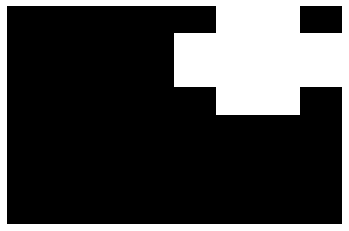

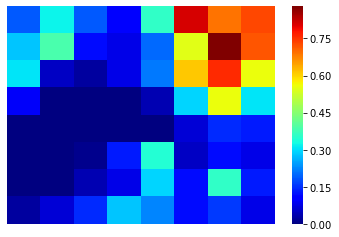

In [6]:
resized_probabilities_mean = figures_with_probabilities(data_test,y_testset, knn_probabilities)

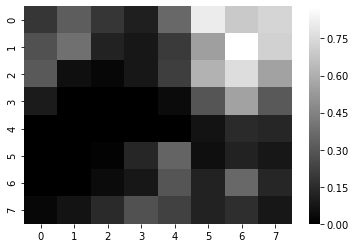

In [8]:
plt.figure()
sns.heatmap(resized_probabilities_mean, cmap = 'gray')
savefig('Predicted labels '+name+method+' Figure 6 gray.ps')